### Import the dataset and using pandas_profiling for preliminary exploratory analysis

In [2]:
from pathlib import Path

import requests
import numpy as np
import pandas as pd

import pandas_profiling
from pandas_profiling.utils.cache import cache_file
#for performing sql query on pandas df
import pandasql as ps

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
#Load the Kaggle cardiovascular dataset after data wrangling

full_data = pd.read_csv('cardiovascular_data_after_data_wrangling.csv', index_col='id')

print(f"The current data shape is {full_data.shape}");
full_data.head()

The current data shape is (68588, 11)


,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
id,,,,,,,,,,,
0,50.391781,0.494708,110,80,0.494708,0.494708,0.494708,0.494708,0.494708,0,21.967120
1,55.419178,0.494708,140,90,0.494708,0.247354,0.247354,0.247354,0.247354,1,34.927679
2,51.663014,0.747354,130,70,0.747354,0.498236,0.498236,0.498236,0.494708,1,23.507805
3,48.282192,0.247354,150,100,0.247354,0.623677,0.623677,0.623677,0.498236,1,28.710479
4,47.873973,0.831569,100,60,0.498236,0.698942,0.698942,0.698942,0.747354,0,23.011177


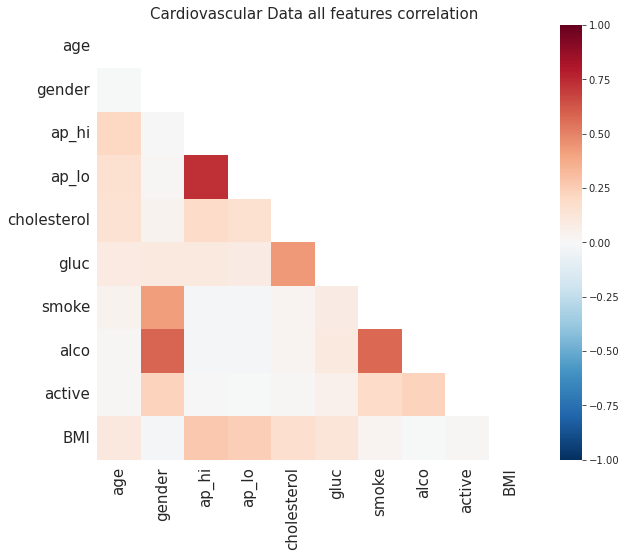

In [4]:
#create the heatmap to check correlation among variables (except for the dependent variable cardio)
df = full_data.drop(columns=['cardio'])
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, cmap='RdBu_r', square=True)

    plt.xticks(rotation=90, size=15)
    '''
    How come only 360 degree works? (Does not make sense!)
    '''
    plt.yticks(rotation=360, size=15)
    
    plt.title("Cardiovascular Data all features correlation", size=15)

### There are strong correlation between ap_lo and ap_hi, as well as some correlation of alcohol vs smoke, smoke vs gender, alcohol vs gender and glucose vs cholesterol levels

In [6]:
#To check whether those features can separate diseased (cardio = 1) and healthy (cardio = 0) samples based on PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


df_scale = pd.DataFrame(scale(df))

df_scale.fillna(method = 'pad', axis=1, inplace=True)

df_pca = PCA().fit(df_scale)

df_pca_x = df_pca.transform(df_scale)




pca_df = pd.DataFrame({'PC1': df_pca_x[:, 0], 'PC2': df_pca_x[:, 1]})
pca_df.head()

,PC1,PC2
0,0.312166,-1.119459
1,29.992088,19.845294
2,-16.076077,-10.235591
3,-0.036591,1.590028
4,-45.610016,-31.161665


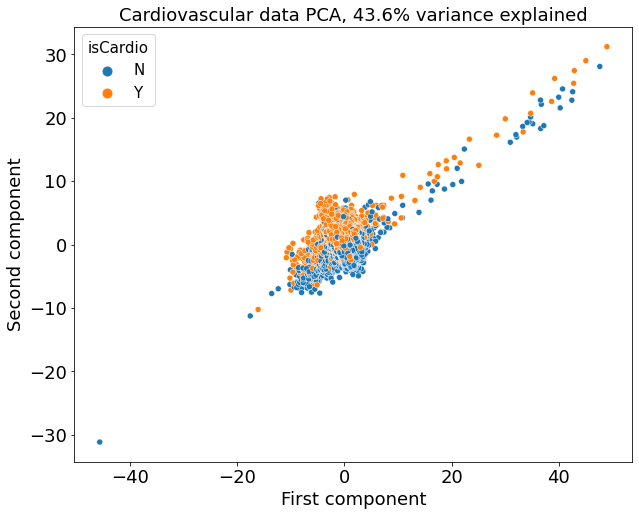

In [7]:
x = np.array(pca_df.PC1)
y = np.array(pca_df.PC2)



#assign back cardio column
pca_df['cardio'] = ['Y' if x==1 else 'N' for x in full_data.cardio]

#quartiles = pca_df.Quartile

pc_var = 100 * df_pca.explained_variance_ratio_.cumsum()[1]
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue='cardio')

ax.set_title(f'Cardiovascular data PCA, {pc_var:.1f}% variance explained', size=18)

ax.set_xlabel('First component', size=18)
ax.set_ylabel('Second component', size=18)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.legend(title='isCardio', title_fontsize=15, loc=2, fontsize=15, markerscale=1.5)

    
plt.show()

### It seems that there is no clear separation of diseased and healthy samples through PCA; Try non-linear dimention reduction method t-SNE instead

In [8]:
#!pip install -U scikit-learn
from sklearn.manifold import TSNE

df_embedded = TSNE(n_components=2).fit_transform(np.array(df_scale))

df_embedded.shape

/root/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(68588, 2)

In [9]:
tsne_df = pd.DataFrame({'tsne_1': df_embedded[:, 0], 'tsne_2': df_embedded[:, 1]})
tsne_df.head()

,tsne_1,tsne_2
0,29.986563,-11.193845
1,17.546366,31.362207
2,16.652378,18.269276
3,10.670964,10.568578
4,16.696255,18.313519


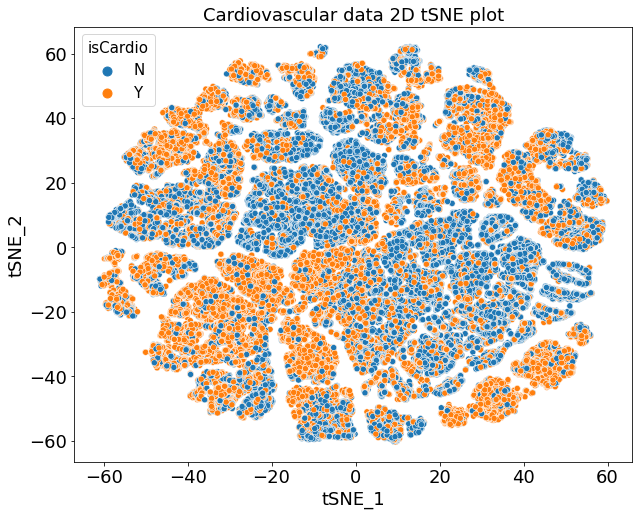

In [10]:
#create tsne plot, colored based on cardio status
x = np.array(tsne_df.tsne_1)
y = np.array(tsne_df.tsne_2)



#assign back cardio column
tsne_df['cardio'] = ['Y' if x==1 else 'N' for x in full_data.cardio]

#quartiles = pca_df.Quartile


fig, ax = plt.subplots(figsize=(10,8))

ax = sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_df, hue='cardio')

ax.set_title(f'Cardiovascular data 2D tSNE plot', size=18)

ax.set_xlabel('tSNE_1', size=18)
ax.set_ylabel('tSNE_2', size=18)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.legend(title='isCardio', title_fontsize=15, loc=2, fontsize=15, markerscale=1.5)

    
plt.show()

### <font color='red'>Can I draw the conclusion that the data cannot be separated with 2 dimensions?</font>

### Next item: check whether any features values are significantly different between health and diseased group

In [11]:
#create a grouped barplot with values of all samples in each group also being displayed

#melt the 'pivot table' to form a proper data structure for plotting
plot_df = pd.melt(full_data, 
            id_vars='cardio', 
            value_vars=list(df.columns), # list of days of the week
            var_name='Features', 
            value_name='Values')


print(plot_df)

        cardio Features     Values
0            0      age  50.391781
1            1      age  55.419178
2            1      age  51.663014
3            1      age  48.282192
4            0      age  47.873973
...        ...      ...        ...
685875       0      BMI  26.927438
685876       1      BMI  50.472681
685877       1      BMI  31.353579
685878       1      BMI  27.099251
685879       0      BMI  24.913495

[685880 rows x 3 columns]


In [12]:

plot_df['isCardio'] = ['Y' if x == 1 else 'N' for x in plot_df.cardio]


#separate features in two groups
#group 1 originally continuous variables
conti_features = ['age', 'ap_hi', 'ap_lo', 'BMI']
conti_plot_df = plot_df.loc[plot_df.Features.isin(conti_features)]


print(f"Shape of continuous variable plot df is {conti_plot_df.shape}, including \
in total {len(conti_features)} features")

#group 2 originally categorical variables
cat_features = list(set(df.columns) - set(conti_features))
cat_plot_df = plot_df.loc[plot_df.Features.isin(cat_features)]

print(f"Shape of categorical variable plot df is {cat_plot_df.shape}, including \
in total {len(cat_features)} features")


Shape of continuous variable plot df is (274352, 4), including in total 4 features
Shape of categorical variable plot df is (411528, 4), including in total 6 features


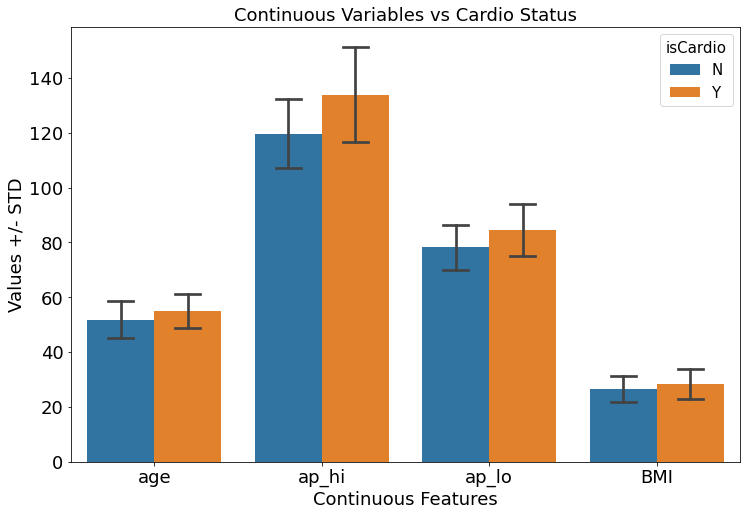

In [13]:
#plot barplot for continuous variables
fig, ax = plt.subplots(figsize=(12,8))

ax = sns.barplot(x="Features", y="Values", hue="isCardio", data=conti_plot_df, ci='sd', capsize=.15)
ax.set_title("Continuous Variables vs Cardio Status", size=18)
ax.set_xlabel('Continuous Features', size=18)
ax.set_ylabel('Values +/- STD', size=18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.legend(title='isCardio', title_fontsize=15, loc=1, fontsize=15, markerscale=1.5)
plt.show()


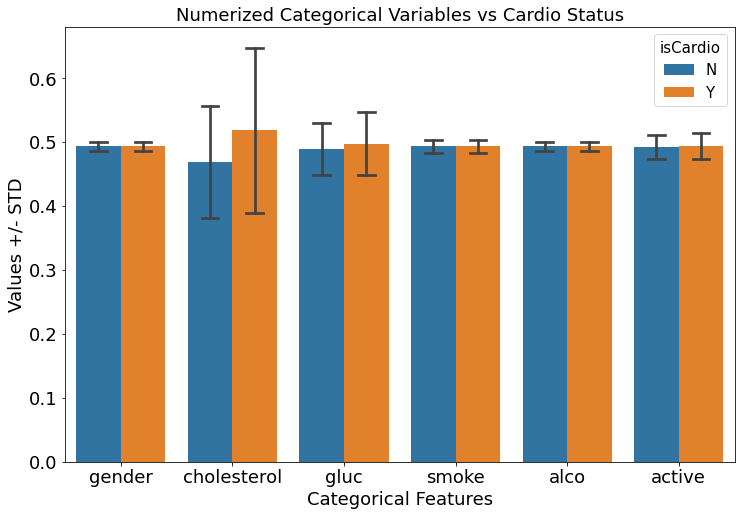

In [14]:
#plot barplot for categorical variables
fig, ax = plt.subplots(figsize=(12,8))

ax = sns.barplot(x="Features", y="Values", hue="isCardio", data=cat_plot_df, ci='sd', capsize=.15)
ax.set_title("Numerized Categorical Variables vs Cardio Status", size=18)
ax.set_xlabel('Categorical Features', size=18)
ax.set_ylabel('Values +/- STD', size=18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.legend(title='isCardio', title_fontsize=15, loc=1, fontsize=15, markerscale=1.5)
plt.show()

## From visualization results, it seems there are significant difference in ap_hi, ap_low and cholesterol levels between diseased and healthy subjects: will test such hypothese

In [15]:
'''
#Performing permutation test on two groups for two sample test
'''

#define function to draw boostrap replicates from a list
def draw_bs_reps(data, func, size):
    #initiate bs replicate array
    bs_replicates = np.empty(size)
    
    #Generate replicates
    for i in range(size):
        sample_i = np.random.choice(data, size=len(data))
        bs_replicates[i] = func(sample_i)
        
    return(bs_replicates)
        

#define function for two sample test
'''
Correct definition of one side or two sided test???
'''

def two_sample_test(group_a, group_b, num_boostrap, twosided=True):
    #concatenate two list to get the overall mean
    concatenate_array = np.concatenate((group_a, group_b))
    overall_mean = np.mean(concatenate_array)
    
    #shift group_a and group_b to equal mean
    group_a_shifted = group_a - np.mean(group_a) + overall_mean
    group_b_shifted = group_b - np.mean(group_b) + overall_mean
    
    
    #compute X num_boostraps replciates from shifted arrays
    bs_replicates_a = draw_bs_reps(group_a_shifted, np.mean, num_boostrap)
    bs_replicates_b = draw_bs_reps(group_b_shifted, np.mean, num_boostrap)
    
    
    bs_diff = bs_replicates_a - bs_replicates_b
    
    if twosided:
        p = np.sum(bs_diff>=np.abs(np.mean(group_a) - np.mean(group_b)))/len(bs_diff)
    else: #one sided test
        p = np.sum(bs_diff>=(np.mean(group_a) - np.mean(group_b)))/len(bs_diff)
    
    
    return(p)



#run the test on ap_hi, ap_lo and cholesterol levels

ap_hi_0 = np.array(full_data.loc[full_data.cardio==0, 'ap_hi'])
ap_hi_1 = np.array(full_data.loc[full_data.cardio==1, 'ap_hi'])

print(f"The probability that healthy and diseased subjects have the same mean ap_hi is \
{two_sample_test(ap_hi_0, ap_hi_1, 10000)}\n")


ap_lo_0 = np.array(full_data.loc[full_data.cardio==0, 'ap_lo'])
ap_lo_1 = np.array(full_data.loc[full_data.cardio==1, 'ap_lo'])

print(f"The probability that healthy and diseased subjects have the same mean ap_lo is \
{two_sample_test(ap_lo_0, ap_lo_1, 10000)}\n")


cholesterol_0 = np.array(full_data.loc[full_data.cardio==0, 'cholesterol'])
cholesterol_1 = np.array(full_data.loc[full_data.cardio==1, 'cholesterol'])

print(f"The probability that healthy and diseased subjects have the same mean cholesterol is \
{two_sample_test(cholesterol_0, cholesterol_1, 10000)}\n")



gender_0 = np.array(full_data.loc[full_data.cardio==0, 'gender'])
gender_1 = np.array(full_data.loc[full_data.cardio==1, 'gender'])

print(f"As a control example, the probability that healthy and diseased subjects have the same gender distribution is \
{two_sample_test(gender_0, gender_1, 10000)}\n")

The probability that healthy and diseased subjects have the same mean ap_hi is 0.0

The probability that healthy and diseased subjects have the same mean ap_lo is 0.0

The probability that healthy and diseased subjects have the same mean cholesterol is 0.0

As a control example, the probability that healthy and diseased subjects have the same gender distribution is 0.4011



### Couple of conclusion drawn from the EDA results:

<b><font size='3'>1. There are strong correlation between ap_hi and ap_lo; Correlation of glucose vs cholestrol, glucose vs smoke, alcohol vs gender and smoke vs gender were also observed.<br>
2. Dataset Features were not able to separate healthy and diseased subjects in two dimensions.<br>
3. However, there are significant difference between the average ap_hi, ap_lo and cholestrol levels of healhty and diseased subjects. <br></b></font>


In [ ]:
#establish baseline (50%)